# **Happy Deliveries Case Study Solutions**

## Data Clean Goals:
- Input errors may have resulted in errors in ‘customer’ dataset 
- Actual payment for order needs to be calculated from the ‘delivery’ dataset
- Orders with the status ‘CANCELLED’ payments should be removed from 
sales since they had to be refunded.

In [8]:
# UPLOAD: DATASETS & LIBRARIES
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [9]:
# Read the order file
delivery = pd.read_csv("../data/hd_orders.csv")

In [12]:
# Read the customer file
customer = pd.read_excel("../data/hd_customers.xlsx")

### Clean Dataset: Look for input errors

#### Task 1: 
- Input errors may have resulted in errors in ‘customer’ dataset

In [15]:
# Display basic information
customer.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406 entries, 0 to 405
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          406 non-null    int64 
 1   first_name  406 non-null    object
 2   last_name   406 non-null    object
 3   age         406 non-null    int64 
 4   city        406 non-null    object
 5   email       406 non-null    object
dtypes: int64(2), object(4)
memory usage: 19.2+ KB


In [17]:
# See the first few rows of the dataframe
customer.head() 

,id,first_name,last_name,age,city,email
0,1001,Samuel,Zavala,139,Dublin,Zavala_Samuel46@xfinity.com
1,1002,Sara,Lee,33,Dublin,Sara.L@hotmail.com
2,1003,Michael,Davidson,23,Dublin,MichaelDavidson82@att.com
3,1004,Willie,Sims,29,Sligo,Willie_S@yahoo.com
4,1005,Carly,Armstrong,22,Mayo,CArmstrong@mail.com


In [19]:
# Count the number of occurrences of each age in the 'age' column
customer["age"].value_counts()

age
22     41
23     35
21     30
24     26
26     26
28     26
30     23
31     21
25     19
33     19
27     15
32     14
29     13
20     13
34     13
19     11
18      8
37      5
35      3
58      3
43      2
36      2
55      2
41      2
45      2
38      2
6       2
42      2
59      2
68      2
67      2
49      2
60      1
62      1
40      1
46      1
75      1
61      1
70      1
139     1
44      1
57      1
53      1
47      1
54      1
8       1
150     1
66      1
71      1
160     1
Name: count, dtype: int64

In [21]:
# Define a function to visualize the outliers
def plot_boxplot(df,ft):
    df.boxplot(column=[ft])
    plt.grid(True)
    plt.show()

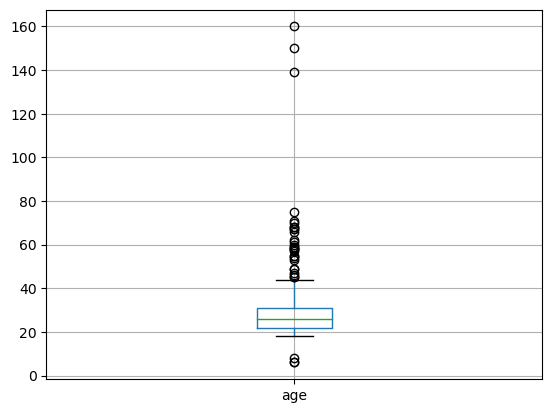

In [23]:
# Show outliers
plot_boxplot(customer,'age')

In [33]:
# Compute the 0.7th percentile and 99.3rd percentile of the 'age' column
# These values are used as thresholds for filtering out outliers or analyzing data distribution
min_threshold,max_threshold=customer["age"].quantile([0.007,0.993])

In [35]:
min_threshold,max_threshold

(16.350000000000005, 85.56000000000131)

In [37]:
# Outlier rows part1
customer[customer["age"]>max_threshold]

,id,first_name,last_name,age,city,email
0,1001,Samuel,Zavala,139,Dublin,Zavala_Samuel46@xfinity.com
30,1031,Jessica,Hendricks,150,Dublin,Jessica.H85@xfinity.com
70,1071,David,Gibson,160,Dublin,DavidGibson@xfinity.com


In [39]:
# Outlier rows part2
customer[customer["age"]<min_threshold]

,id,first_name,last_name,age,city,email
59,1060,Amy,Farmer,8,Kerry,Farmer.Amy@verizon.com
102,1103,Andrew,Craig,6,Dublin,Andrew.C74@yahoo.com
164,1165,Christopher,Ramsey,6,Waterford,Ramsey_Christopher@hotmail.com


In [41]:
# Removing outliers
customer_clean=customer[(customer["age"]<max_threshold) & (customer["age"]>min_threshold)]

In [43]:
# Check the null values
customer_clean.isnull().sum()

id            0
first_name    0
last_name     0
age           0
city          0
email         0
dtype: int64

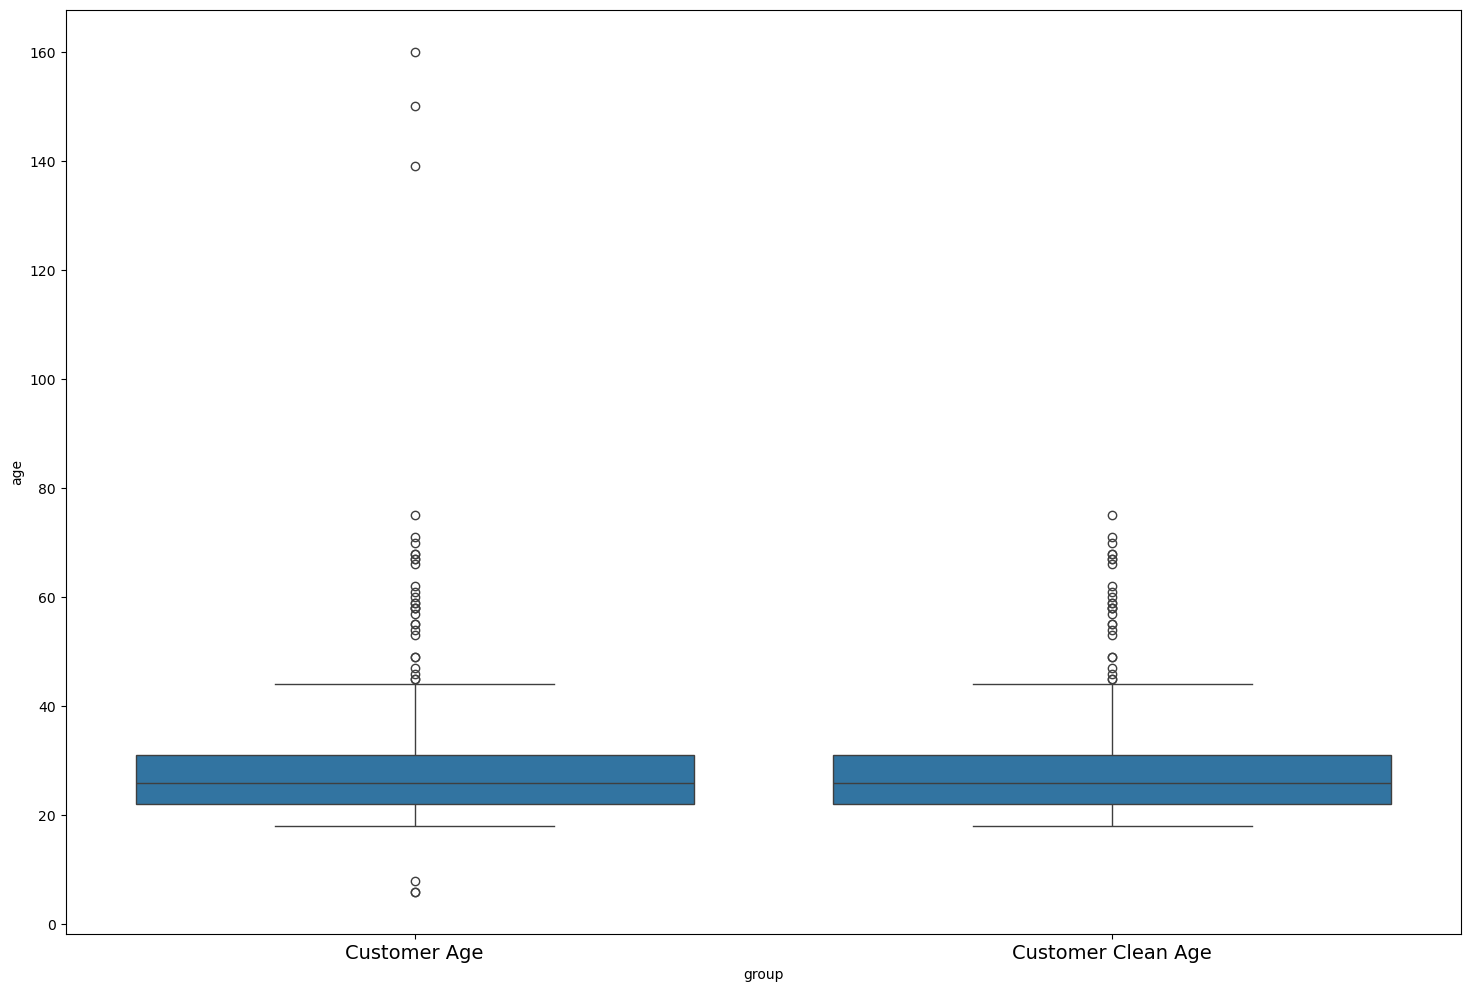

In [47]:
# Comparison before and after cleaning
# Create a figure and axis for plotting with a specified size
fig, ax = plt.subplots(figsize=(18, 12))

# Combine the 'age' data from both the original and cleaned DataFrames
# Create a DataFrame with age data from the original and cleaned datasets
# 'group' column is used to differentiate between the original and cleaned data
combined_data = pd.DataFrame({
    'age': customer['age'].tolist() + customer_clean['age'].tolist(),
    'group': ['Customer'] * len(customer) + ['Customer Clean'] * len(customer_clean)
})

# Create a boxplot to visualize the distribution of 'age' before and after cleaning
# 'x' axis represents the group (Original vs Cleaned), and 'y' axis represents 'age'
sns.boxplot(x='group', y='age', data=combined_data, ax=ax)

# Set the labels for the x-axis ticks to indicate the groups being compared
ax.set_xticks([0, 1])
ax.set_xticklabels(['Customer Age', 'Customer Clean Age'], fontsize=14)

# Display the plot
plt.show()

In [45]:
# Getting a summary of the dataset's distribution and basic statistical properties
customer_clean.describe()

,id,age
count,400.000000,400.000000
mean,1205.475000,28.622500
std,116.924496,9.753863
min,1002.000000,18.000000
25%,1105.750000,22.000000
50%,1206.500000,26.000000
75%,1306.250000,31.000000
max,1406.000000,75.000000


#### Task 2: 
- Actual payment for order needs to be calculated from the ‘delivery’ dataset.

In [51]:
# Check the column names
delivery.columns

Index(['order_id', 'order_timestamp', 'delivered_timestamp', 'driver_id',
       'restaurant_id', 'cust_id', 'delivery_region', 'discount_applied',
       'discount_code', 'order_total', 'discount_pc', 'status'],
      dtype='object')

In [53]:
# Check the null values
delivery.isnull().sum()

order_id                 0
order_timestamp          0
delivered_timestamp      7
driver_id                0
restaurant_id            0
cust_id                  0
delivery_region          0
discount_applied         0
discount_code          906
order_total              0
discount_pc            906
status                   0
dtype: int64

In [57]:
# Column "discount_pc" is used in later calculation
delivery['discount_pc'].fillna(0, inplace=True)

In [59]:
# Check the total null values in column 'discount_pc'
delivery["discount_pc"].isnull().sum()

0

In [61]:
# Delivery_df['actual_payment'] = delivery_df['order_total'] - (delivery_df['order_total'] * (delivery_df['discount_pc']/100))
delivery["payment"]=delivery["order_total"]*(1-delivery["discount_pc"].apply(float)/100)

In [63]:
# Check the first 5 rows of delivery table
delivery.head()

,order_id,order_timestamp,delivered_timestamp,driver_id,restaurant_id,cust_id,delivery_region,discount_applied,discount_code,order_total,discount_pc,status,payment
0,100001,26/11/2021 18:22,26/11/2021 18:49,273,105,1016,Dublin,True,BLACKFRIDAY21,69.46,20.0,COMPLETED,55.568
1,100002,11/7/2021 21:23,11/7/2021 21:53,43,219,1017,Cork,False,NaN,69.40,0.0,COMPLETED,69.400
2,100003,27/04/2021 17:28,27/04/2021 17:55,299,48,1019,Dublin,False,NaN,47.16,0.0,COMPLETED,47.160
3,100004,22/02/2021 18:08,22/02/2021 18:35,320,233,1020,Dublin,False,NaN,47.15,0.0,COMPLETED,47.150
4,100005,21/06/2021 18:14,21/06/2021 18:44,41,207,1024,Dublin,False,NaN,47.00,0.0,COMPLETED,47.000


#### Task 3: 
- Orders with the status ‘CANCELLED’ payments should be removed from sales since they had to be refunded.

In [68]:
# Check the null values
delivery.isnull().sum()

order_id                 0
order_timestamp          0
delivered_timestamp      7
driver_id                0
restaurant_id            0
cust_id                  0
delivery_region          0
discount_applied         0
discount_code          906
order_total              0
discount_pc              0
status                   0
payment                  0
dtype: int64

In [70]:
# Count the number of occurrences of each unique value in the 'status' column
delivery["status"].value_counts()

status
COMPLETED    991
CANCELLED      7
Name: count, dtype: int64

In [72]:
# Remove the status "CANCELLED" equal to keep the status "COMPLETED"
delivery_clean = delivery[delivery["status"]=="COMPLETED"]

In [74]:
# Check the numbers of status completed
delivery_clean["status"].isnull().sum()

0

In [76]:
# JOINING THE DATASETS
delivery_clean.columns

Index(['order_id', 'order_timestamp', 'delivered_timestamp', 'driver_id',
       'restaurant_id', 'cust_id', 'delivery_region', 'discount_applied',
       'discount_code', 'order_total', 'discount_pc', 'status', 'payment'],
      dtype='object')

In [78]:
# Check the columns name
customer_clean.columns

Index(['id', 'first_name', 'last_name', 'age', 'city', 'email'], dtype='object')

In [82]:
# Customers - id => deliveries - cust_id
merged=pd.merge(delivery_clean,customer_clean,left_on="cust_id",right_on="id",how="inner")

In [84]:
# Check the first 5 rows to see the result
merged.head()

,order_id,order_timestamp,delivered_timestamp,driver_id,restaurant_id,cust_id,delivery_region,discount_applied,discount_code,order_total,discount_pc,status,payment,id,first_name,last_name,age,city,email
0,100001,26/11/2021 18:22,26/11/2021 18:49,273,105,1016,Dublin,True,BLACKFRIDAY21,69.46,20.0,COMPLETED,55.568,1016,Michael,Rodriguez,24,Limerick,Michael_R@comcast.net
1,100328,5/6/2021 20:38,5/6/2021 21:08,351,140,1016,Dublin,False,NaN,16.55,0.0,COMPLETED,16.550,1016,Michael,Rodriguez,24,Limerick,Michael_R@comcast.net
2,100500,30/04/2022 21:03,30/04/2022 21:39,175,48,1016,Dublin,False,NaN,46.62,0.0,COMPLETED,46.620,1016,Michael,Rodriguez,24,Limerick,Michael_R@comcast.net
3,100753,2/11/2022 19:15,2/11/2022 19:49,168,321,1016,Galway,False,NaN,26.66,0.0,COMPLETED,26.660,1016,Michael,Rodriguez,24,Limerick,Michael_R@comcast.net
4,100002,11/7/2021 21:23,11/7/2021 21:53,43,219,1017,Cork,False,NaN,69.40,0.0,COMPLETED,69.400,1017,Mr.,Joseph,23,Limerick,MHorne@zoho.com


In [86]:
# Before and after merge 
delivery_clean['cust_id'].nunique(),customer_clean['id'].nunique(),merged["id"].nunique()

(405, 400, 399)

In [88]:
# Numbers of the null rows
delivery[delivery['delivered_timestamp'].isnull()].shape[0]

7

### Quenstion 1: 
- Compare monthly 2021 sales to 2022 and determine has ‘Happy Deliveries’ sales grown.

In [92]:
# Check the type of "order_timestamp"
merged.dtypes

order_id                 int64
order_timestamp         object
delivered_timestamp     object
driver_id                int64
restaurant_id            int64
cust_id                  int64
delivery_region         object
discount_applied          bool
discount_code           object
order_total            float64
discount_pc            float64
status                  object
payment                float64
id                       int64
first_name              object
last_name               object
age                      int64
city                    object
email                   object
dtype: object

In [96]:
# STEP 1 =  Convert date to correct datatype part 1
merged['delivered_timestamp'] = pd.to_datetime(merged['delivered_timestamp'],dayfirst=True)

In [98]:
# Convert date to correct datatype part 2
merged['order_timestamp'] = pd.to_datetime(merged['order_timestamp'],dayfirst=True)

In [100]:
# STEP 2 =  Extract date and create columns for year
merged['year'] = merged['order_timestamp'].dt.year

In [102]:
# Extract date and create columns for month
merged['month'] = merged['order_timestamp'].dt.month

In [104]:
# Check the result
merged.head()

,order_id,order_timestamp,delivered_timestamp,driver_id,restaurant_id,cust_id,delivery_region,discount_applied,discount_code,order_total,...,status,payment,id,first_name,last_name,age,city,email,year,month
0,100001,2021-11-26 18:22:00,2021-11-26 18:49:00,273,105,1016,Dublin,True,BLACKFRIDAY21,69.46,...,COMPLETED,55.568,1016,Michael,Rodriguez,24,Limerick,Michael_R@comcast.net,2021,11
1,100328,2021-06-05 20:38:00,2021-06-05 21:08:00,351,140,1016,Dublin,False,NaN,16.55,...,COMPLETED,16.550,1016,Michael,Rodriguez,24,Limerick,Michael_R@comcast.net,2021,6
2,100500,2022-04-30 21:03:00,2022-04-30 21:39:00,175,48,1016,Dublin,False,NaN,46.62,...,COMPLETED,46.620,1016,Michael,Rodriguez,24,Limerick,Michael_R@comcast.net,2022,4
3,100753,2022-11-02 19:15:00,2022-11-02 19:49:00,168,321,1016,Galway,False,NaN,26.66,...,COMPLETED,26.660,1016,Michael,Rodriguez,24,Limerick,Michael_R@comcast.net,2022,11
4,100002,2021-07-11 21:23:00,2021-07-11 21:53:00,43,219,1017,Cork,False,NaN,69.40,...,COMPLETED,69.400,1017,Mr.,Joseph,23,Limerick,MHorne@zoho.com,2021,7


In [106]:
# STEP 3 = Select each year from data
# Select 2021
sales_2021 = merged[merged['year'] == 2021]

In [108]:
# Select 2022
sales_2022 = merged[merged['year'] == 2022]

In [110]:
# Count the number of occurrences of each unique value in the 'year' column in 2021
sales_2021['year'].value_counts()

year
2021    389
Name: count, dtype: int64

In [114]:
# Count the number of occurrences of each unique value in the 'year' column in 2022
sales_2022['year'].value_counts()

year
2022    583
Name: count, dtype: int64

In [116]:
# Count the number of occurrences of each unique value in the 'month' column in 2021
sales_2021["month"].value_counts()

month
11    71
12    50
8     40
6     35
7     33
5     31
10    29
4     26
3     23
9     22
2     20
1      9
Name: count, dtype: int64

In [120]:
# Get total sales by month in 2021
monthly_21 = sales_2021.groupby('month')['payment'].sum().to_frame('Payment')

In [122]:
# Check the result
monthly_21

,Payment
month,
1,197.040
2,531.030
3,552.204
4,724.450
5,852.407
6,965.194
7,924.700
8,1125.684
9,516.010


In [124]:
# Get total sales by month in 2022
monthly_22 = sales_2022.groupby('month')['payment'].sum().to_frame('Payment')

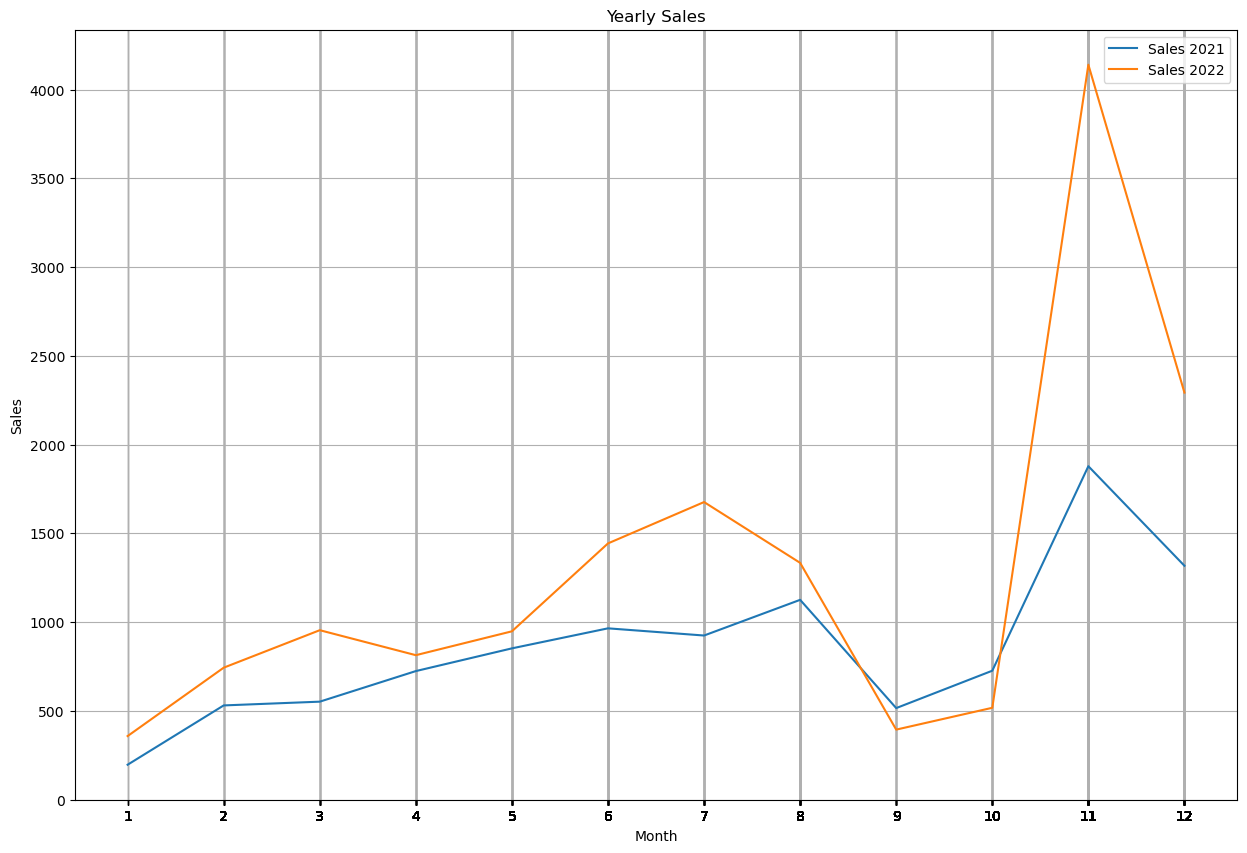

In [126]:
# Create a new figure with a specified size for the plot
fig = plt.figure(figsize=(15,10))

# Define labels for the legend to differentiate between the two years
label=["Sales 2021","Sales 2022"]

# Plot the monthly payment data for 2021
plt.plot(monthly_21.index,monthly_21['Payment'])

# Plot the monthly payment data for 2022
plt.plot(monthly_22.index,monthly_22['Payment'])

# Add a legend to the plot to identify the two lines
plt.legend(label)

# Set the x-axis ticks to the months present in the 'sales_2021' DataFrame
plt.xticks(sales_2021['month'])

# Enable the grid for better readability of the plot
plt.grid(True)

# Set the title and labels of the plot
plt.title("Yearly Sales",fontsize=15)
plt.xlabel("Month")
plt.ylabel("Sales")

# Display the plot
plt.show()

In [128]:
# Method2
# Group sales data by month and calculate total sales for each month
sales = merged.groupby(['year', 'month'])['payment'].sum()

In [130]:
# From series to DataFrame
monthly_sales=pd.DataFrame(data=sales)

In [134]:
# Check the result
monthly_sales

payment
year month          
2021 1       197.040
     2       531.030
     3       552.204
     4       724.450
     5       852.407
     6       965.194
     7       924.700
     8      1125.684
     9       516.010
     10      726.507
     11     1878.311
     12     1317.590
2022 1       358.430
     2       743.610
     3       954.687
     4       814.010
     5       948.392
     6      1443.540
     7      1676.430
     8      1333.940
     9       394.790
     10      517.680
     11     4139.566
     12     2292.880

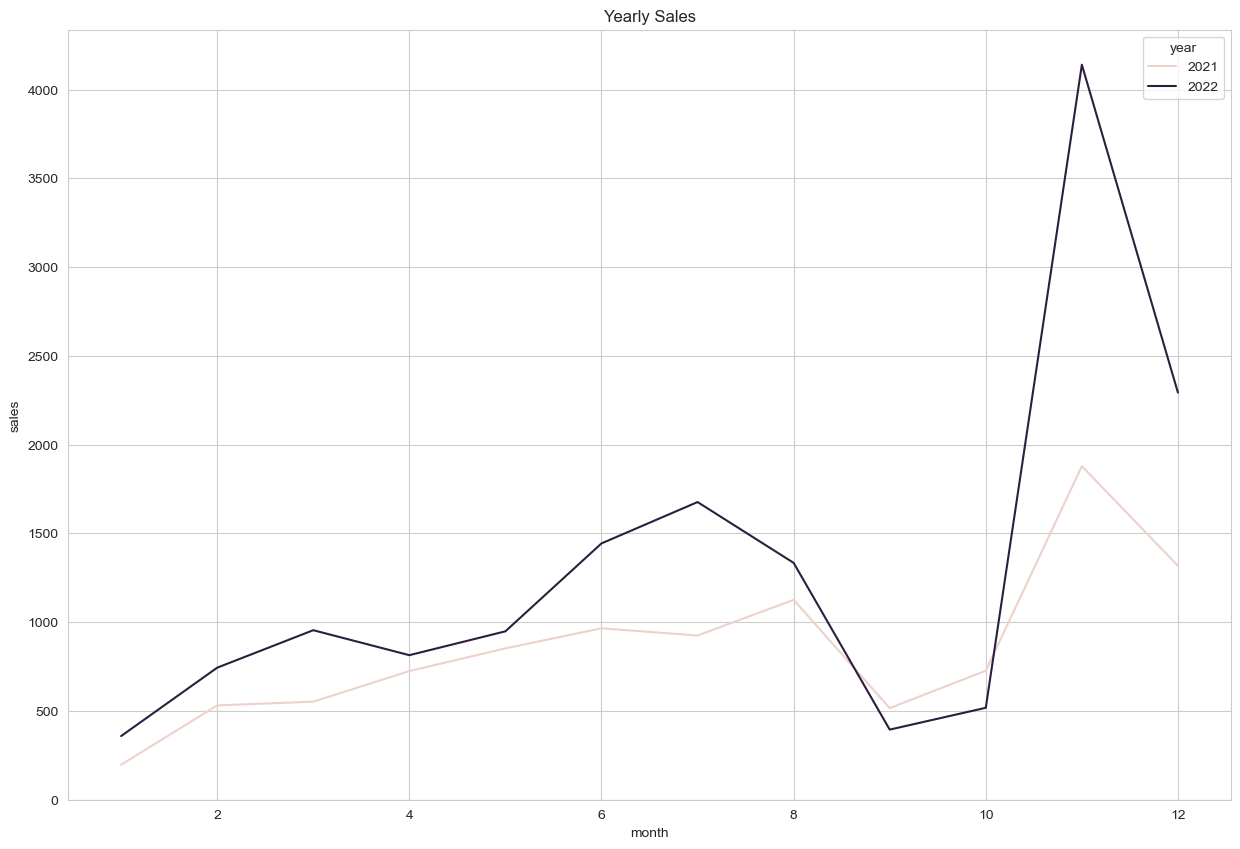

In [136]:
# Create a new figure with a specified size for the plot
fig = plt.figure(figsize=(15,10))

# Set the style of the plot to 'whitegrid' for a cleaner look
sns.set_style("whitegrid")

# Create a line plot using seaborn to visualize the monthly sales data
sns.lineplot(x='month',y='payment', hue='year', data=monthly_sales)
plt.title('Yearly Sales',fontsize=15)
plt.xlabel('month')
plt.ylabel('sales')

# Display the plot
plt.show()

### Quenstion 2: 
- Looking to the loyalty card holders, what is the age distribution of those customers.

In [146]:
# Check the customer clean table
customer_clean.head(1)

,id,first_name,last_name,age,city,email
1,1002,Sara,Lee,33,Dublin,Sara.L@hotmail.com


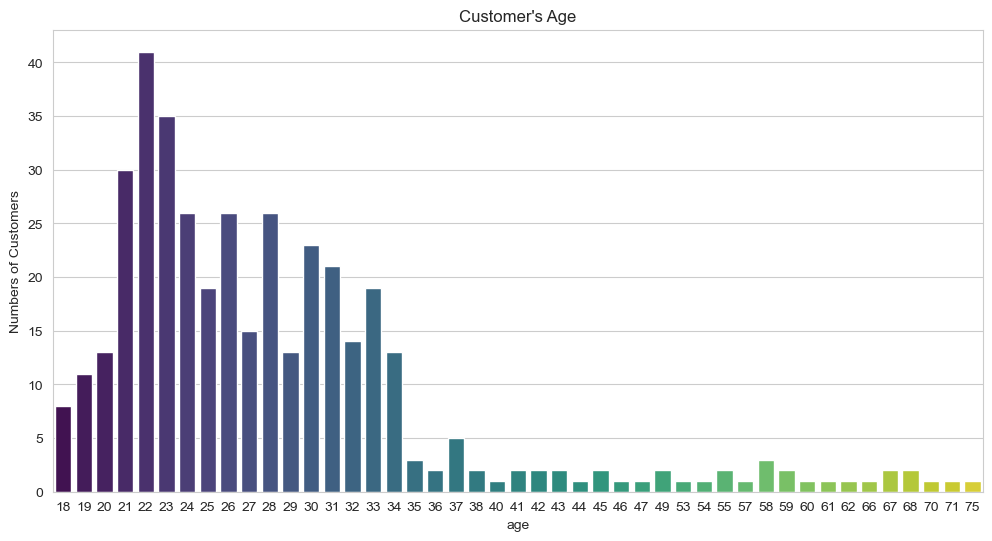

In [148]:
# Create a new figure with a specified size for the plot
plt.figure(figsize=(12, 6))

# Create a count plot using seaborn to visualize the distribution of customer ages
ax=sns.countplot(x='age',data=customer_clean,palette='viridis')

# Set the title and labels of the plot
ax.set_title("Customer's Age",fontsize=15)
ax.set_ylabel("Numbers of Customers")

# Display the plot
plt.show()

In [150]:
# # Count the number of occurrences of each unique value in the 'age' column 
merged['age'].value_counts()

age
22    102
23     85
31     74
28     69
26     63
24     57
21     57
30     55
33     51
25     43
32     38
20     33
34     32
27     32
29     26
19     24
18     20
59     10
58      9
68      8
35      7
37      7
67      6
42      6
44      5
45      5
66      4
43      4
41      4
49      4
55      3
46      3
47      3
71      3
54      3
36      2
75      2
40      2
60      2
70      2
62      2
38      2
61      1
57      1
53      1
Name: count, dtype: int64

In [152]:
# Show the mean,median and mode of age 
customer_clean["age"].mean(),customer_clean["age"].median(),customer_clean["age"].mode()

(28.6225,
 26.0,
 0    22
 Name: age, dtype: int64)

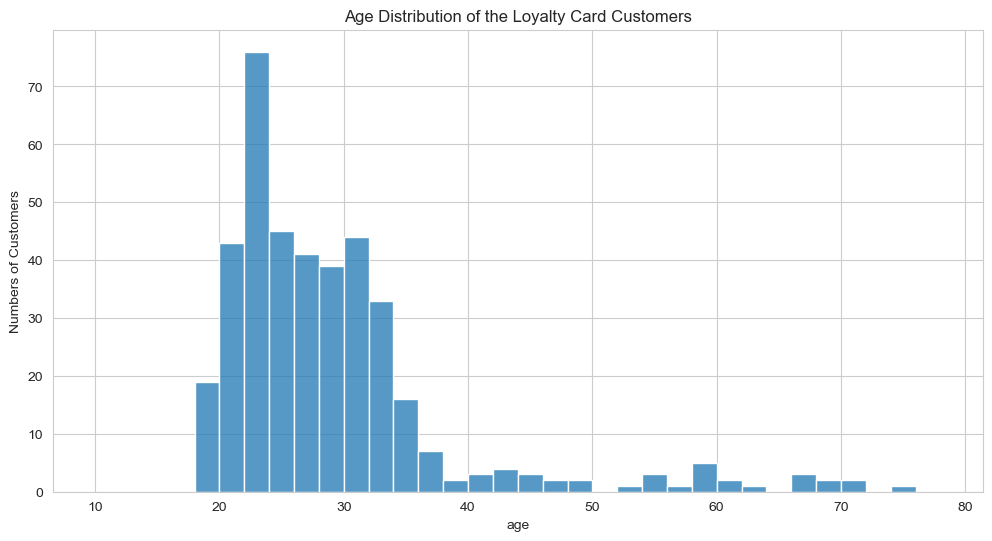

In [154]:
# Create a new figure with a specified size for the plot
fig = plt.figure(figsize=(12,6))

# Create a histogram plot using seaborn to visualize the age distribution of loyalty card customers
# 'bins' defines the range and number of bins for the histogram, here ranging from 10 to 80 with a bin width of 2
ax=sns.histplot(customer_clean['age'],bins=np.arange(10, 80, 2),kde=False)

# Set the title and ylabel of the plot
ax.set_title("Age Distribution of the Loyalty Card Customers",fontsize=15)
ax.set_ylabel("Numbers of Customers")

# Display the plot
plt.show()

### Question 3: 
- Is there a relationship between the amount spend by a loyalty card holder and their age?

In [157]:
# Relation 1： destribution of amount spend and age by using scatter
# Check the column name
merged.columns

Index(['order_id', 'order_timestamp', 'delivered_timestamp', 'driver_id',
       'restaurant_id', 'cust_id', 'delivery_region', 'discount_applied',
       'discount_code', 'order_total', 'discount_pc', 'status', 'payment',
       'id', 'first_name', 'last_name', 'age', 'city', 'email', 'year',
       'month'],
      dtype='object')

In [159]:
# Calculate the total payment amount for each person,because one customer may have more than one orders
group_age_sum_payment = merged.groupby(['cust_id', 'age'])['payment'].sum().to_frame('payment_total').reset_index()

In [161]:
# Check the result
group_age_sum_payment

,cust_id,age,payment_total
0,1002,33,42.89
1,1003,23,38.16
2,1004,29,49.09
3,1005,22,66.98
4,1006,26,40.38
...,...,...,...
394,1402,27,24.92
395,1403,28,24.71
396,1404,55,24.63
397,1405,24,24.49


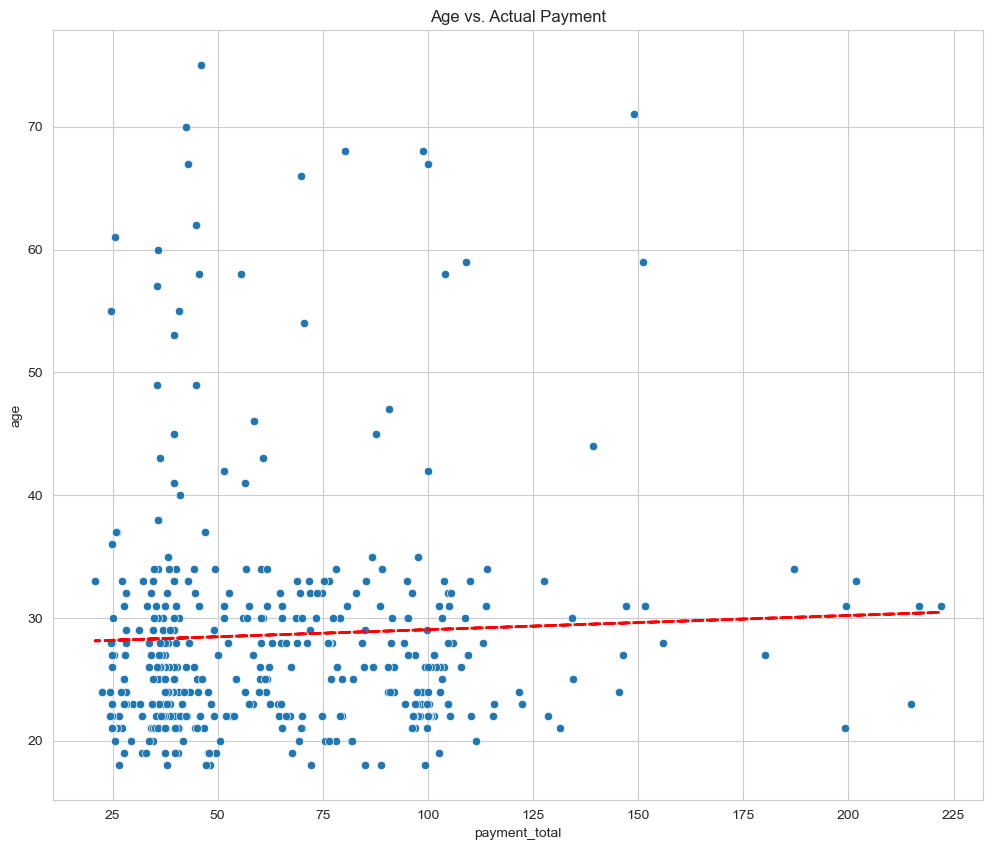

In [163]:
# Create a new figure with a specified size for the plot
plt.figure(figsize=(12, 10))

# Create a scatter plot using seaborn to visualize the relationship between total payment and age
ax=sns.scatterplot(x=group_age_sum_payment["payment_total"], y=group_age_sum_payment["age"],data=group_age_sum_payment) 

# Compute the line of best fit using linear regression
x = group_age_sum_payment["payment_total"]
y = group_age_sum_payment["age"]

# Calculate the slope (a) and intercept (b) of the line of best fit
a, b = np.polyfit(x,y,1)

# Plot the line of best fit on the scatter plot
ax.plot(x, a*x+b,  color='red', linestyle='--', linewidth=2)

# Set the title of the plot to describe the relationship being shown
plt.title('Age vs. Actual Payment',fontsize=15)

# Display the plot
plt.show()

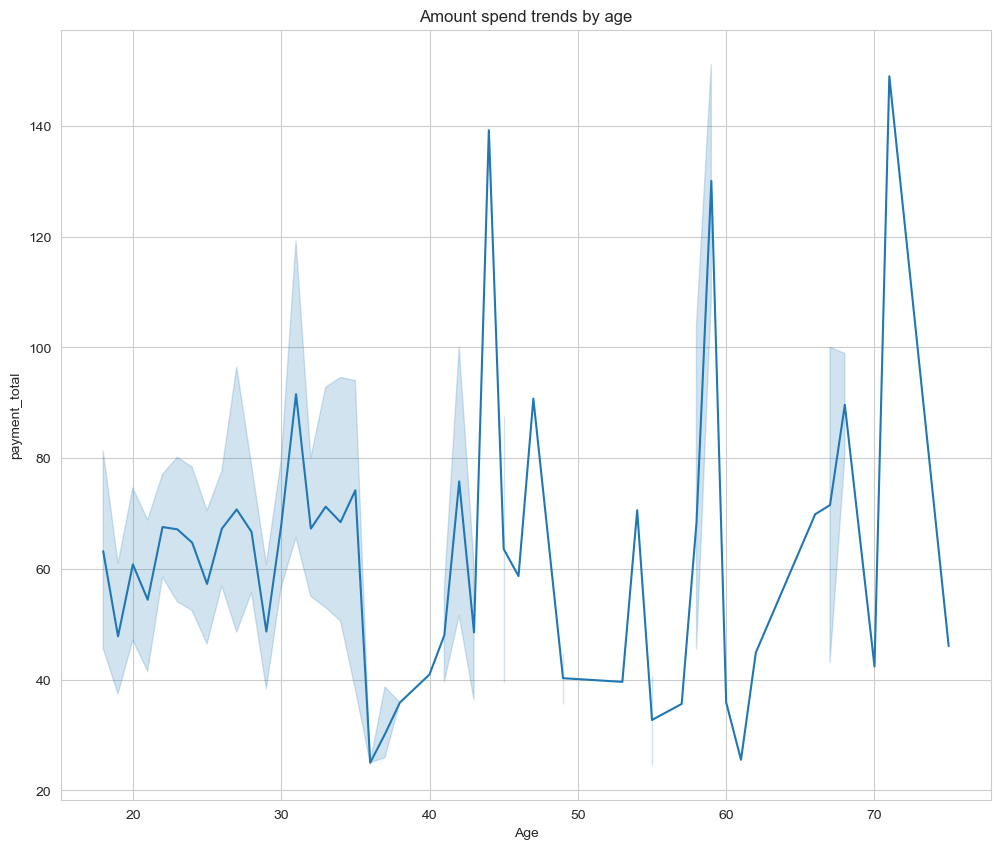

In [165]:
# Relation 2： total amount spend trends with age by using linechart
# Create a new figure with a specified size for the plot
plt.figure(figsize=(12, 10))

# Create a line plot using seaborn to visualize the trend of total amount spent by age
sns.lineplot(x='age',y='payment_total', data=group_age_sum_payment)

# Set the title and labels of the plot
plt.title('Amount spend trends by age',fontsize=15)
plt.xlabel('Age')
plt.ylabel=('Amount spend')

# Display the plot
plt.show()

In [167]:
# Compute the correlation matrix for 'age' and 'payment_total'
corr=group_age_sum_payment[['age','payment_total']].corr()

In [169]:
# Display the correlation matrix
corr

,age,payment_total
age,1.000000,0.042766
payment_total,0.042766,1.000000


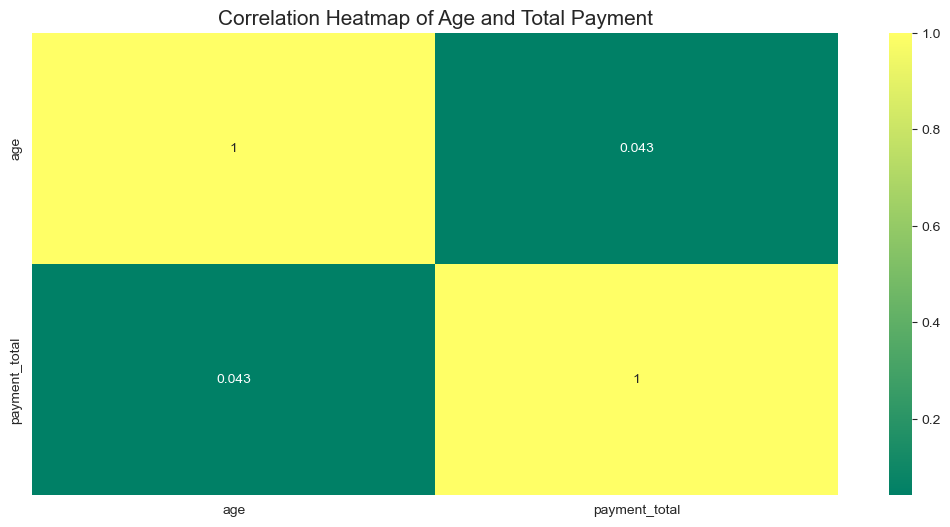

In [177]:
# Create a new figure with a specified size for the heatmap
plt.figure(figsize=(13, 6))

# Create a heatmap using seaborn to visualize the correlation matrix
sns.heatmap(corr,cmap='summer',annot=True)

# Set the title of the heatmap to describe what is being shown
plt.title('Correlation Heatmap of Age and Total Payment', fontsize=15)

# Display the heatmap
plt.show()

### Question 4: 
- Is there a relationship between the amount of a payment, the age of a person and whether or not they used discount codes.


In [180]:
# Count the number of occurrences of each unique value in the 'discount_applied' column 
merged['discount_applied'].value_counts()

discount_applied
False    882
True      90
Name: count, dtype: int64

In [182]:
# Create a DataFrame with selected columns
discount_df=merged[['cust_id','age','payment','discount_applied','discount_code']]

In [184]:
# Show some of the result
discount_df.head()

,cust_id,age,payment,discount_applied,discount_code
0,1016,24,55.568,True,BLACKFRIDAY21
1,1016,24,16.550,False,NaN
2,1016,24,46.620,False,NaN
3,1016,24,26.660,False,NaN
4,1017,23,69.400,False,NaN


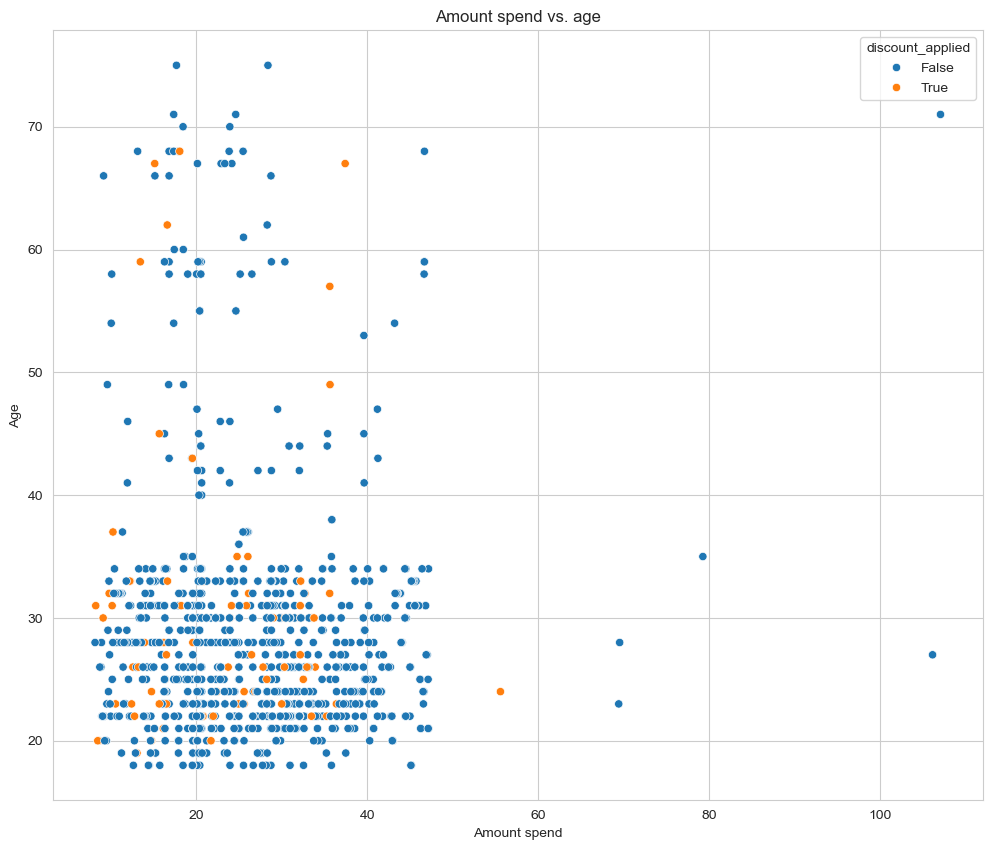

In [186]:
# STEP 1 = SCATTERPLOT OF DISCOUNT APPLIED TRUE / FALSE
# Create a new figure with a specified size for the plot
plt.figure(figsize=(12, 10))

# Create a scatter plot to visualize the relationship between payment amount and age
ax=sns.scatterplot(x='payment',y='age', hue='discount_applied', data=discount_df)

# Set the title and labels of the plot 
ax.set_title('Amount spend vs. age',fontsize=15)
ax.set_xlabel('Amount spend')
ax.set_ylabel('Age')

# Display the plot
plt.show()

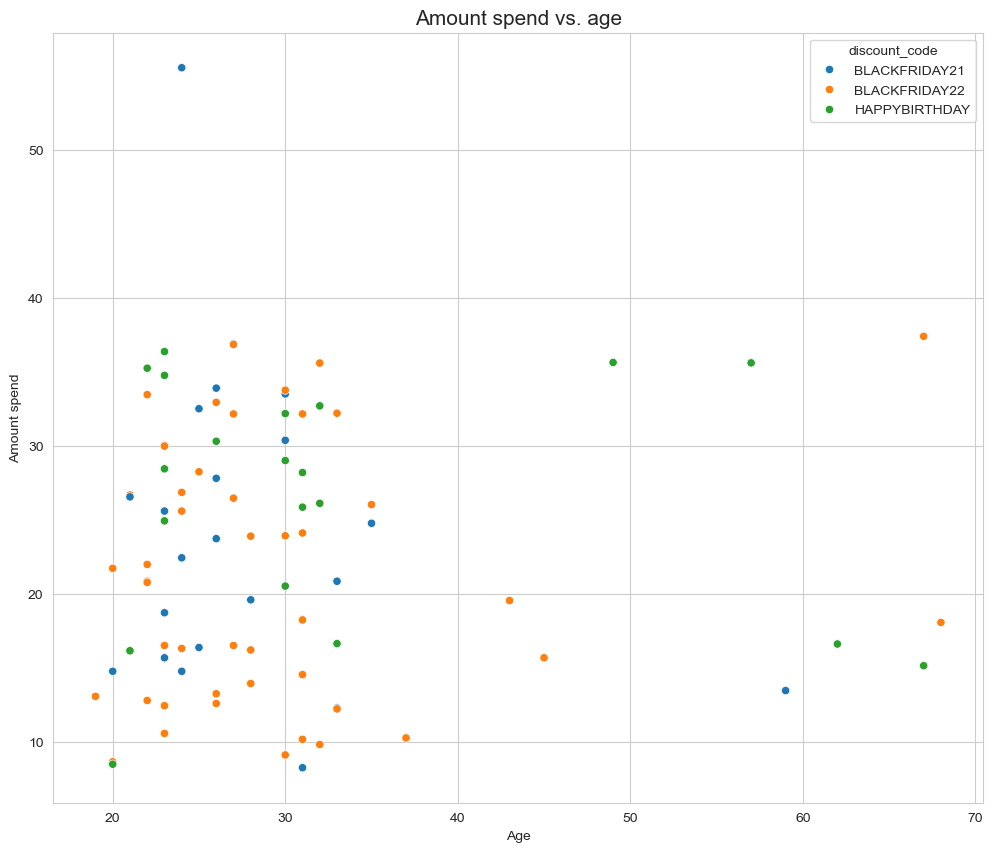

In [192]:
# STEP 2 = SCATTERPLOT OF ACTUAL DISCOUNTS APPLIED
# Create a new figure with a specified size for the plot
plt.figure(figsize=(12,10))

# Create a scatter plot to visualize the relationship between age and payment amount
ax=sns.scatterplot(x='age',y='payment', hue='discount_code', data=discount_df)

# Set the title and lables of the plot
ax.set_title('Amount spend vs. age',fontsize=15)
ax.set_xlabel('Age') 
ax.set_ylabel('Amount spend')

# Display the plot
plt.show()

### Question 5: 
- Compare the sales for 2022 across all regions

In [197]:
# STEP 1 = CALCULATE TOTAL SALES PER REGION
region_sales2022=sales_2022.groupby(['delivery_region'])['payment'].sum().reset_index().sort_values(by='payment', ascending=False)

In [199]:
# Check the result
region_sales2022

,delivery_region,payment
1,Dublin,6732.098
0,Cork,3456.407
2,Galway,2650.840
3,Kerry,1399.640
5,Sligo,885.080
4,Leitrim,493.890


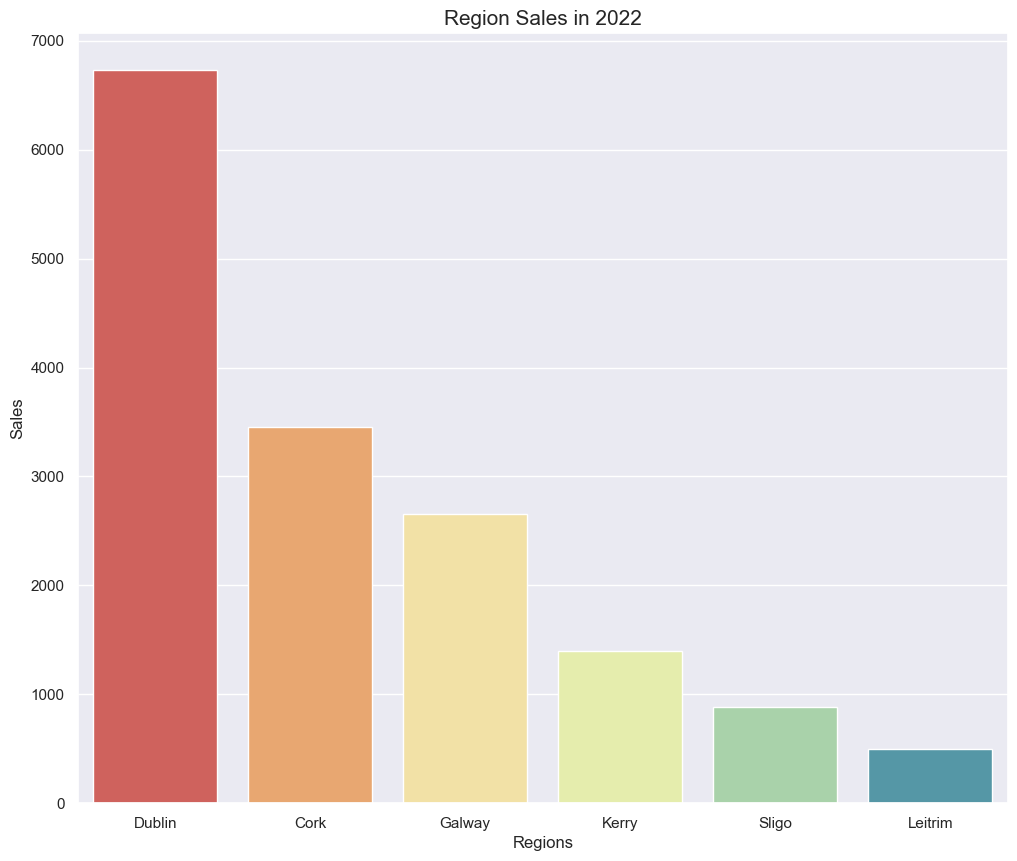

In [203]:
# STEP 2 = GRAPH THE REGIONS BY TOTAL SALES IN A BAR PLOT
# Create a new figure and axis with a specified size for the plot
figure,ax=plt.subplots(figsize=(12,10))

# Set the style of the plot to 'darkgrid' for a grid backgro
sns.set(style='darkgrid')

# Create a bar plot to visualize sales by delivery region for 2022
ax=sns.barplot(x='delivery_region', y='payment', data=region_sales2022, palette = "Spectral")

# Set the title and labels of the plot
ax.set_title("Region Sales in 2022",fontsize=15)
ax.set_xlabel('Regions')
ax.set_ylabel('Sales')

# Display the plot
plt.show()

### Question 6: 
- Christmas is coming and Happy Deliveries want to reward their high spending customers. Who are the top 10 highest spending customers in 2022? Find their ID, name and email address for the marketing department to contact them with a reward. 


In [206]:
# Step 1 = Get the total spent in 2022
top_22=sales_2022.groupby(['cust_id'])['payment'].sum().to_frame('total_spent').sort_values(by='total_spent',ascending=False).reset_index()

In [208]:
# Check the result
top_22.head()

,cust_id,total_spent
0,1027,146.492
1,1126,146.300
2,1009,131.640
3,1023,118.300
4,1021,115.130


In [210]:
# Step 2=Check the ranking if there is a duplicated rank number
# Adding extra column called 'rank_min'
top_22['rank_min']=top_22['total_spent'].rank(method='min',ascending=False)

In [212]:
# Adding extra column called 'rank_dense'
top_22['rank_dense']=top_22['total_spent'].rank(method='dense',ascending=False)

In [214]:
# Display the top 20 rows of the DataFrame with columns for total amount spent, minimum rank, and dense rank
top_22[['total_spent','rank_min','rank_dense']].head(20)

,total_spent,rank_min,rank_dense
0,146.492,1.0,1.0
1,146.300,2.0,2.0
2,131.640,3.0,3.0
3,118.300,4.0,4.0
4,115.130,5.0,5.0
5,105.220,6.0,6.0
6,103.940,7.0,7.0
7,102.080,8.0,8.0
8,99.380,9.0,9.0
9,96.176,10.0,10.0


In [216]:
# Filter to under 10
result=top_22.loc[top_22['rank_min']<11]

In [218]:
# Recreate the dataframe
result = pd.DataFrame(result)

In [220]:
# Remove the 'rank_min' and 'rank_dense' columns from the DataFrame and update it in place
result.drop(['rank_min','rank_dense'],axis=1,inplace=True)

In [222]:
# Check the result
customer_clean.head()

,id,first_name,last_name,age,city,email
1,1002,Sara,Lee,33,Dublin,Sara.L@hotmail.com
2,1003,Michael,Davidson,23,Dublin,MichaelDavidson82@att.com
3,1004,Willie,Sims,29,Sligo,Willie_S@yahoo.com
4,1005,Carly,Armstrong,22,Mayo,CArmstrong@mail.com
5,1006,Greg,Hardin,26,Leitrim,Hardin_Greg@gmail.com


In [228]:
# Step 3 = Rejoin to original df with left join
result_details=pd.merge(result,customer_clean,left_on='cust_id',right_on='id',how='left')[['cust_id','total_spent','first_name','last_name','email']]

In [233]:
# Check the result
result_details

,cust_id,total_spent,first_name,last_name,email
0,1027,146.492,Jason,Dudley,Jason_D@zoho.com
1,1126,146.300,Deanna,Knight,DeannaKnight@protonmail.com
2,1009,131.640,Sheri,Aguilar,Aguilar.Sheri22@att.com
3,1023,118.300,Gabrielle,Morgan,GMorgan48@mail.com
4,1021,115.130,Joshua,Kidd,Joshua_K@att.com
5,1018,105.220,David,Snyder,David.S@hotmail.com
6,1227,103.940,Andrew,Cantu,Andrew_Cantu@yandex.com
7,1028,102.080,David,Murphy,Murphy.David@mail.com
8,1059,99.380,Brent,Harrell,Harrell.Brent13@protonmail.com
9,1029,96.176,Meagan,Gonzalez,Gonzalez_Meagan43@mail.com


### Question 7: 
- In order to keep up with the anticipated increase in sales over Christmas, Happy Deliveries want to find what are the top 3 restaurants, so they can allocate their resources more efficiently. What are the top 3 restaurants in terms of sales for 2022? 


In [236]:
# Summarize total sales per restaurant, sort in descending order, and reset index
top_rest_22=sales_2022.groupby(['restaurant_id'])['payment'].sum().to_frame('restaurant_sales').sort_values(by='restaurant_sales',ascending=False).reset_index()

In [240]:
# Check the result
top_rest_22.head()

,restaurant_id,restaurant_sales
0,9,671.894
1,107,638.422
2,8,564.360
3,20,523.216
4,68,439.228


In [241]:
# Extract the first 3 records
top3=top_rest_22.head(3)

In [244]:
# Check the result
top3

,restaurant_id,restaurant_sales
0,9,671.894
1,107,638.422
2,8,564.360


### Question 8: 
- The marketing department wants to reach out to non-returning loyalty card customers from 2021 in hopes they can lower their customer churn rate. Find all the customers who are considered non-returning including their id, name and email. 

In [248]:
# Customer purchase only onece in 2021
order_count=merged.groupby('cust_id')['order_id'].count().to_frame('order_count')

In [250]:
# Check the result
order_count

,order_count
cust_id,
1002,2
1003,2
1004,3
1005,3
1006,2
...,...
1402,1
1403,1
1404,1


In [252]:
# Filter orders with exactly one occurrence to identify non-returning customers
one_order=order_count[order_count['order_count']==1]

In [260]:
# Count the number of occurrences of each unique value in the 'order_count column 
one_order['order_count'].value_counts()

order_count
1    109
Name: count, dtype: int64

In [262]:
# Check the result
one_order.head()

,order_count
cust_id,
1113,1
1114,1
1115,1
1116,1
1120,1


In [264]:
# Reset the index of the DataFrame to ensure 'order_count' is a column and not an index
one_order.reset_index(inplace = True)

In [266]:
# Check the result
one_order.head()

,cust_id,order_count
0,1113,1
1,1114,1
2,1115,1
3,1116,1
4,1120,1


In [268]:
# list of all cust ids who purchased once

# But these purchases could be in 2022 / 2021

one_order["cust_id"]

0      1113
1      1114
2      1115
3      1116
4      1120
       ... 
104    1402
105    1403
106    1404
107    1405
108    1406
Name: cust_id, Length: 109, dtype: int64

In [270]:
# Customer nummers with unique order in 2021
cust_one_p_2021=pd.merge(one_order,sales_2021,on='cust_id',how='inner')

In [272]:
# Check the result
cust_one_p_2021.head()

,cust_id,order_count,order_id,order_timestamp,delivered_timestamp,driver_id,restaurant_id,delivery_region,discount_applied,discount_code,...,status,payment,id,first_name,last_name,age,city,email,year,month
0,1129,1,100052,2021-02-16 17:56:00,2021-02-16 18:23:00,63,91,Dublin,False,NaN,...,COMPLETED,40.15,1129,Taylor,Martinez,31,Galway,Martinez_Taylor@aol.com,2021,2
1,1130,1,100053,2021-09-03 21:27:00,2021-09-03 21:57:00,277,6,Cork,False,NaN,...,COMPLETED,40.15,1130,Justin,Alvarez,31,Dublin,Alvarez_Justin95@comcast.net,2021,9
2,1135,1,100054,2021-10-29 20:28:00,2021-10-29 20:58:00,179,10,Cork,False,NaN,...,COMPLETED,39.71,1135,Marco,Simpson,25,Limerick,MarcoSimpson@aol.com,2021,10
3,1137,1,100055,2021-07-19 18:19:00,2021-07-19 18:49:00,156,68,Cork,False,NaN,...,COMPLETED,39.66,1137,Nicholas,Fernandez,29,Dublin,NFernandez@comcast.net,2021,7
4,1139,1,100056,2021-10-16 21:40:00,2021-10-16 22:16:00,195,241,Cork,False,NaN,...,COMPLETED,39.63,1139,Lori,Lawson,41,Dublin,Lawson.Lori@mail.com,2021,10


In [274]:
# Extract unique cust_id form sales_2021
solution=cust_one_p_2021[['cust_id','first_name','last_name','email']]

In [276]:
# Count the number of the customer
len(solution)

50

In [278]:
# Show the result
solution.head()

,cust_id,first_name,last_name,email
0,1129,Taylor,Martinez,Martinez_Taylor@aol.com
1,1130,Justin,Alvarez,Alvarez_Justin95@comcast.net
2,1135,Marco,Simpson,MarcoSimpson@aol.com
3,1137,Nicholas,Fernandez,NFernandez@comcast.net
4,1139,Lori,Lawson,Lawson.Lori@mail.com


### Question 9: 
- The sales team want to find out if the discount code ‘BLACKFRIDAY22’ was as successful as last years ‘BLACKFRIDAY21’. Find the total amount of sales from both discount codes.

In [281]:
# Finding tht amount (count) of discount codes usesd
merged['discount_code'].value_counts()

discount_code
BLACKFRIDAY22    45
BLACKFRIDAY21    24
HAPPYBIRTHDAY    21
Name: count, dtype: int64

In [285]:
# Amount of sales from BLACKFRIDAY21
sales21=sales_2021.groupby('discount_code').get_group('BLACKFRIDAY21')['payment'].sum()

In [287]:
# Check the result
sales21

579.2320000000001

In [291]:
# Amount of sales from BLACKFRIDAY22
sales22=sales_2022.groupby('discount_code').get_group('BLACKFRIDAY22')['payment'].sum()

In [293]:
# Check the result
sales22

954.0160000000002

In [298]:
# Conditional judgment
if sales22>sales21:
    print("BLACKFRIDAY22 was more successful than BLACKFRIDAY21")
elif sales22<sales21:
    print("BLACKFRIDAY22 was less successful than BLACKFRIDAY21")
else:
    print("BLACKFRIDAY22 was as successful as BLACKFRIDAY21")

#\n

print('Sales 2022: €', sales22, '\nSales 2021: €', sales21)

BLACKFRIDAY22 was more successful than BLACKFRIDAY21
Sales 2022: € 954.0160000000002 
Sales 2021: € 579.2320000000001


### Question 10: 
- What were the locations with the lowest cumulative sales for 2022? Should the marketing department tailor their marketing efforts more towards this location (Perhaps other factors are responsible for example low population) 

In [301]:
# Total sales in regions 
region_sales=sales_2022.groupby('delivery_region')['payment'].sum().to_frame('Payment').sort_values(by='Payment',ascending=True)

In [307]:
# Check the result
region_sales

,Payment
delivery_region,
Leitrim,493.890
Sligo,885.080
Kerry,1399.640
Galway,2650.840
Cork,3456.407
Dublin,6732.098


In [311]:
# Identify the region with the lowest sales
lower_region=region_sales.idxmin().iloc[0]

In [313]:
# Check the result
lower_region

'Leitrim'

In [315]:
# Get the minimum sales amount across all regions
lower_payment=region_sales.min().iloc[0]

In [317]:
# Check the result
lower_payment

493.89

In [319]:
# Create a DataFrame with the region having the lowest sales and the corresponding sales amount
lower=pd.DataFrame({'lower_region':[lower_region],'region_sales':[lower_payment]})

In [321]:
# Check the result
lower

,lower_region,region_sales
0,Leitrim,493.89


In [323]:
f'locations with the lowest cumulative sales for 2022: {lower_region} ({lower_payment})'

'locations with the lowest cumulative sales for 2022: Leitrim (493.89)'